In [751]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib
import json
from pathlib import Path
import seaborn as sns
import pandas as pd
from scipy.ndimage.filters import uniform_filter1d
import sys
sys.path.append('..')
import neatplot
neatplot.set_style()
neatplot.update_rc('font.size', 20)
matplotlib.rcParams['text.usetex'] = True
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\DeclareMathOperator{\EIG}{EIG}')
%matplotlib inline

In [752]:
# sns.set_theme()

In [753]:
base_path = Path('../experiments')
baseline_path = Path('../../bac-baselines/experiments')
base_hucrl_path = Path('../../hucrl/exps/mujoco/experiments')
process_seeds = True

In [783]:
env_name = r'Short Lava'

In [784]:
pend_paths = {# 'BAC (seed 12)': 'random_init_12_2021-08-05/10-02-01/',
         # 'BAC': 'pend_norm_tele_mg_3mc_2021-08-16/21-16-21',
         #'Rollout BAC': 'rollout_bac_telenorm_multi_2021-08-17/22-44-48/',
        'TIP': 'rollout_pendulum_2022-02-04/09-20-00/', 
        'sTIP': 'sum_barl_pendulum_2022-05-14/13-50-51/',
        'BARL': 'bac_pendulum_2021-09-30/10-03-18/',
         # 'RQMPC': 'random_pendulum_2021-09-30/13-06-45/',
         'DIP': 'rus_pendulum_2022-05-15/00-33-31/',
         'sDIP': 'sus_pendulum_2022-05-14/23-25-06/',
         r'$\EIG_T$': 'us_pendulum_2021-10-02/17-05-00/',
         'MPC': 'mbrl_pendulum_2021-09-30/12-16-37/',
         # 'PETS': 'pets_pendulum_2021-09-26/12-05-56/',
         # 'SAC': 'sac_pendulum_2021-09-30/12-44-00/',
         # 'TD3': 'td3_pendulum_2021-10-01/11-50-44/',
         # 'PPO': 'ppo_pendulum_2021-09-30/15-58-55',
         # 'Rollout BARL': 'rollout_bac_pendulum_2022-01-24/10-23-32/',
         
         # 'HUCRL': 'hucrl_pendulum_2022-05-05/18-43-22/',
         # 'TS': 'hucrl_pendulum_thompson_2022-04-22/22-23-56/',
         # 'HUCRL (greedy)': 'hucrl_pendulum_greedy_2022-04-25/06-59-17/',
        
        }

In [785]:
cartpole_paths = {
         # 'BAC': 'cartpole_multistart_2021-08-20/12-52-46/',
         'TIP': 'rollout_cartpole_2022-05-05/18-53-31/',
         'sTIP': 'sum_barl_cartpole_2022-05-10/18-23-29/',
         'BARL': 'bac_cartpole_2021-09-30/10-06-18/',
         # 'RQMPC': 'random_cartpole_2021-09-30/14-41-06/',
         'DIP': 'rus_cartpole_2022-05-14/18-59-34/',
         'sDIP': 'sus_cartpole_2022-05-14/18-22-14/',
         r'$\EIG_T$': 'us_cartpole_2021-10-02/18-03-05/',
         'MPC': 'mbrl_cartpole_2021-09-30/14-23-08/',
         
         # 'RUS': 'default_2022-05-13/09-49-33/',
         # 'RUS2': 'default_2022-05-14/13-01-19/'
         # 'Rollout BAC': 'cartpole_multistart_rollout_bac_2021-08-19/17-59-03/',
         # 'PETS': 'pets_cartpole_2021-09-26/12-17-26/',
         # 'KGRL': 'kgrl_cartpole_3init_2021-12-29/15-04-25/',
         # 'SAC': 'sac_cartpole_2021-09-30/12-46-23/',
         # 'TD3': 'td3_cartpole_2021-10-01/11-59-14/',
         # 'PPO': 'ppo_cartpole_2021-10-01/13-04-31/',
         # 'Rollout BARL': 'fast_rollout_bac_cartpole_2022-01-23/12-06-50',
         
         # Open Loop BARL': 'cartpole_open_loop_fixed_2022-02-08/11-47-42/',
         # 'BARL (New)': 'no_bayes_cartpole_barl_2022-03-27/12-45-16/',
         # 'BARL (Bayes)': 'bayes_cartpole_barl_2022-03-27/13-57-28/',
         # 'HUCRL': 'hucrl_cartpole_2022-05-05/18-57-44/',
         # 'TS': 'hucrl_cartpole_thompson_2022-05-05/18-57-44/',
         # 'HUCRL (greedy)': 'hucrl_cartpole_greedy_2022-05-05/18-57-44/',
}

In [786]:
lava_paths = {
        # 'BAC': 'bac_lava_path_2021-09-09/10-57-31/',
        'BARL': 'bac_lava_path_2021-09-25/11-47-59/',
        # 'RQMPC': 'random_lava_path_2021-09-30/22-58-35/',
        'MPC': 'mbrl_lava_path_2021-09-25/14-30-03/',
        r'US': 'us_lava_path_2021-10-02/18-27-22/',
        'PETS': 'pets_lava_path_2021-10-03/11-17-05/',
        'SAC': 'sac_lava_path_2021-09-30/12-45-03/',
        'TD3': 'td3_lava_path_2021-10-01/12-06-39/',
        'PPO': 'ppo_lava_path_2021-10-01/17-35-57/',
}

In [787]:
short_lava_paths = {
        'oTIP': 'open_loop_bac_short_lava_2022-05-03/12-32-46/',
        'oMPC': 'open_loop_mpc_short_lava_2022-05-03/12-38-24/',
        'oDIP': 'open_loop_us_short_lava_2022-05-03/12-40-19/',
        'BO': "bayes_opt_short_lava_2022-04-22/14-31-40/",
}

In [788]:
reacher_paths = {
        # 'BAC (uniform)': 'bac_reacher_2021-09-01/17-14-04/',
        # 'BAC (path sampling)': 'bac_reacher_rand_2021-09-01/17-14-02/',
        
        # 'BAC (ARD)': 'ard_reacher_bac_2021-09-18/14-59-33/',
        # 'BAC (periodic ARD)':'reacher_periodic_bac_2021-09-18/15-26-28/',
        # 'BAC (heavy path)': 'bac_reacher_heavy_paths_2021-09-27/09-48-01/',
        # 'BAC (noisy heavy path)': 'bac_reacher_noisy_heavy_path_2021-09-29/13-21-31',
        'TIP': 'rollout_reacher_2022-02-04/10-28-59/',
        'sTIP': 'sum_barl_reacher_2022-05-10/18-25-38/',
        'BARL': 'bac_reacher_2021-09-29/10-38-12/',
        'DIP': 'rus_reacher_2022-05-16/21-07-35/', ## this is one seed, the next one is currently comnig
        'sDIP': 'sus_reacher_2022-05-16/10-25-57/',
        r'$\EIG_T$': 'us_reacher_2021-10-03/12-01-24/',
        # 'RQMPC': 'random_reacher_2021-10-01/16-03-06/',
        'MPC': 'mbrl_reacher_2021-09-30/22-54-56/',
        
        # 'Sum TIP': 'sum_barl_reacher_2022-05-10/18-25-38/',
        # 'PETS': 'pets_reacher_2021-09-30/17-18-38/',
        # 'SAC': 'sac_reacher_2021-09-30/17-29-38/',
        # 'TD3': 'td3_reacher_2021-10-01/11-53-22/',
        # 'PPO': 'ppo_reacher_2021-09-30/19-36-17/',
        # 'HUCRL': 'hucrl_reacher_2022-05-05/16-17-43/',
        # 'TS': 'hucrl_reacher_thompson_2022-05-05/16-17-43/',
        # 'HUCRL (greedy)': 'hucrl_reacher_greedy_2022-05-05/16-17-43/',
        
}

In [789]:
beta_tracking_paths = {
        'TIP': 'rollout_beta_tracking_2022-02-04/10-23-51/',
        'sTIP': 'sum_barl_beta_tracking_2022-05-14/13-51-51/',
        'BARL': 'bac_beta_tracking_2021-09-25/12-14-51/',
        'DIP': 'rus_barl_beta_tracking_2022-05-15/13-43-47/',
        'sDIP': 'sus_barl_beta_tracking_2022-05-15/12-22-34/',
        r'$\EIG_T$': 'us_beta_tracking_2021-10-02/22-41-29/',
        'MPC': 'mbrl_beta_tracking_2021-09-25/13-57-02/',
        # 'PETS': 'pets_beta_tracking_2021-10-03/11-23-07/',
        # 'SAC': 'sac_beta_tracking_2021-10-04/11-17-56/',
        # 'TD3': 'td3_beta_tracking_2022-05-10/17-01-17/',
        # 'PPO': 'ppo_beta_tracking_2021-10-04/13-17-42/',

        # 'HUCRL': 'hucrl_beta_tracking_2022-04-22/12-16-34/',
        # "TS": 'hucrl_beta_tracking_thompson_2022-05-05/19-19-46/',
        # 'HUCRL (greedy)': 'hucrl_beta_tracking_greedy_2022-04-22/02-25-54/',
        
}

In [790]:
beta_rotation_paths = {
    'TIP': 'tip_beta_rotation_tracking_2022-05-10/14-08-44/',
    'sTIP': 'sum_barl_beta_rotation_tracking_2022-05-14/13-52-46/',
    'BARL': 'barl_beta_rotation_tracking_2022-05-10/14-08-27/',
    'DIP': 'rus_beta_rotation_tracking_2022-05-16/12-47-05/',
    'sDIP': 'sus_beta_rotation_tracking_2022-05-16/10-30-28/',
    r'$\EIG_T$': 'us_beta_rotation_tracking_2022-05-10/15-34-29/',
    'MPC': 'mpc_beta_rotation_tracking_2022-05-10/14-09-36/',

    # 'PETS': 'pets_beta_rotation_tracking_2022-05-09/21-38-53/',
    # 'SAC': 'sac_beta_rotation_tracking_2022-05-10/10-38-04/',
    # 'TD3': 'td3_beta_rotation_tracking_2022-05-10/14-30-48/',
    # 'PPO': 'ppo_beta_rotation_tracking_2022-05-10/16-57-30/',
    # 'HUCRL': 'hucrl_beta_rotation_tracking_2022-05-10/11-13-00/',
    # 'TS': 'hucrl_beta_rotation_tracking_thompson_2022-05-09/22-02-42/',
    # 'HUCRL (greedy)': 'hucrl_beta_rotation_tracking_greedy_2022-05-10/04-46-01/',
}

In [791]:
weird_gain_paths = {
    # 'BARL': 'weird_gain_barl_2022-02-12/23-15-12/',
    # 'Open Loop BARL': 'weird_gain_open_loop_barl_2022-02-17/10-01-50/',
    # 'Rollout BARL': 'weird_gain_rollout_barl_2022-02-12/23-15-16/',
    # 'Start State BARL': 'weird_gain_ss_barl_2022-02-12/23-15-10/',
    # 'SAS BARL': 'weird_gain_ss_barl3mc_sas_2022-02-22/08-55-27/',
    # 'MBRL': 'weird_gain_mpc_2022-02-12/23-15-08/',
    # r'$EIG_T$': 'weird_gain_us_2022-02-12/23-15-08/',
    
    # 'Bayesian Optimization': 'sklearn_opt_weird_gain_2022-02-16/22-55-50/',
    # 'BARL (recent)': 'no_bayes_weird_gain_2022-03-27/11-41-53/',
    # 'BARL (Bayes)': 'bayes_weird_gain_2022-03-27/12-23-23/',
    
    'oTIP': 'open_loop_bac_weird_gain_2022-05-03/12-13-26/',
    'oMPC': 'open_loop_mpc_weird_gain_2022-05-03/12-20-04/',
    r'oDIP': 'open_loop_us_weird_gain_2022-05-03/12-21-41/',
    'BO': 'bayes_opt_weird_gain_2022-04-22/13-07-56/',
}

In [792]:
weirder_gain_paths = {
    'oTIP': 'open_loop_bac_weirder_gain_2022-05-15/17-58-06/',
    'oMPC': 'open_loop_mpc_weirder_gain_2022-05-15/18-27-20/',
    r'oUS': 'open_loop_us_weirder_gain_2022-05-15/18-29-40/',
    'BO': 'bayes_opt_weirder_gain_2022-05-15/17-59-22/',
}

In [793]:
beta_tracking_fixed_paths = {
    'oTIP': 'open_loop_bac_beta_tracking_fixed_2022-05-15/18-26-44/',
    'oMPC': 'open_loop_mpc_beta_tracking_fixed_2022-05-15/19-02-39/',
    r'oUS': 'open_loop_us_beta_tracking_fixed_2022-05-15/19-06-13/',
    'BO': 'bayes_opt_beta_tracking_fixed_2022-05-15/18-35-21/',
    
}

In [794]:
plasma_tracking_paths = {
        'Rollout BARL': 'rollout_barl_plasma_tracking_2022-02-21/16-58-08/',
        'Rollout BARl (2)': 'rollout_barl_plasma_tracking_2022-03-22/09-51-58/',
        'BARL': 'bac_plasma_tracking_2021-10-03/13-12-50/',
        # 'BARL (new)': 'new_plasma_tracking_2021-10-11/13-31-22/',
        # 'RQMPC': ''
        'MPC': 'mbrl_plasma_tracking_2021-10-03/13-03-07/',
        r'US': 'us_plasma_tracking_2021-10-04/07-41-47',
        'PETS': 'pets_plasma_tracking_2021-10-01/15-53-40/',
        'SAC': 'sac_plasma_tracking_2021-10-02/23-01-19/',
        'TD3': 'td3_plasma_tracking_2021-10-03/01-05-24/',
        'PPO': 'ppo_plasma_tracking_2021-10-03/02-13-23/',
    
        'Open Loop BARL': 'open_loop_barl_plasma_tracking_2022-02-21/17-04-09/',
        'Bayes Opt': 'bayes_opt_plasma_tracking_2022-02-22/09-17-01/',
}

In [795]:
reacher_tight_paths = {
        #'BAC (ARD)': 'bac_reacher_tight_ard_2021-09-21/10-06-46/',
        #'Random (ARD)': 'random_reacher_tight_ard_2021-09-21/23-56-00/',
        'BAC (path sampling)': 'bac_reacher_tight_paths_2021-09-25/10-58-57/',
        'BAC (heavy hypers)': 'bac_reacher_tight_heavy_hypers_2021-09-25/10-58-04/',
        'BAC (heavy path)': 'bac_reacher_tight_heavy_paths_2021-09-26/14-38-26/',
        'PETS': 'pets_reacher_tight_2021-09-22/18-59-17/',
        'PETS': ''
        # 'SAC': 'sac_reacher_tight_2021-09-22/18-34-13/',
        # 'TD3': 'td3_reacher_tight_2021-09-22/15-24-00/',
        # 'PPO': 'ppo_reacher_tight_2021-09-22/15-25-08/',
}

In [796]:
swimmer_paths = {
        'BAC (ARD)': 'bac_swimmer_ard_2021-09-17/15-13-29/',
        'BAC (new)': 'bac_swimmer_new_2021-10-11/16-39-16/',
    
}

In [797]:
env_time_lengths ={
     'Reacher': 50,
     'Pendulum': 200,
     'Cartpole': 25,
     r'$\beta$ Tracking': 30,
     r'$\beta$ + Rotation': 20,
     r'$\beta$ Tracking Fixed': 15,
    }

In [798]:
env_eig_horizons = {
    r'$\beta$ + Rotation': 5,
    'Pendulum': 15,
    'Reacher': 15,
    'Cartpole': 15,
    r'$\beta$ Tracking': 5,
    'Weirder Gain': 10,
    r'$\beta$ Tracking Fixed': 15,
}
eig_horizon = env_eig_horizons[env_name]

KeyError: 'Short Lava'

In [799]:
rollout_methods = {"TIP", "oTIP", "Sum TIP"}

In [800]:
all_paths = {"Cartpole": cartpole_paths,
             "Pendulum": pend_paths,
             "Reacher": reacher_paths, 
             'Lava Path': lava_paths, 
             'Short Lava': short_lava_paths,
             "Reacher (tight)": reacher_tight_paths,
             r"$\beta$ Tracking": beta_tracking_paths,
             r"$\beta$ Tracking Fixed": beta_tracking_fixed_paths,
             'Swimmer': swimmer_paths,
             'Plasma Tracking': plasma_tracking_paths,
             'Weird Gain': weird_gain_paths,
             'Weirder Gain': weirder_gain_paths,
             r'$\beta$ + Rotation': beta_rotation_paths,
            }
paths = all_paths[env_name]
gt = {"Pendulum": -200,
      "Cartpole": -12.5,
      "Reacher": -5,
      'Lava Path': -30,
      'Short Lava': -7.75,
      'Reacher (tight)': -8.78,
      'Swimmer': 30,
      r'$\beta$ Tracking': -2,
      r'$\beta$ Tracking Fixed': -2.,# 'RQMPC': 'random_beta_tracking_2021-09-25/14-08-07/',
      r'$\beta$ + Rotation': -2,
      'Plasma Tracking': -5,
      'Weird Gain': -110,
      'Weirder Gain': -93,
     }
ylim_bottom = {
        "Pendulum": -1500,
        "Cartpole": -25,
        "Reacher": -15,
        "Lava Path": -3000,
        'Short Lava': -10,
        r"$\beta$ Tracking": -12,
        "Plasma Tracking": -40,
        "Swimmer": -30,
        r"$\beta$ Tracking Fixed": -20,
        "Weird Gain": -200,
        "Weirder Gain": -430,
        r"$\beta$ + Rotation": -20
}
gt_val = gt[env_name]
bottom_val = ylim_bottom[env_name]

In [801]:
def process_bac(data):
    returns = np.vstack(data['Eval Returns'])

    data['Eval Mean Returns'] = returns.mean(axis=1)
    data['Eval Std Returns'] = returns.std(axis=1)#  / np.sqrt(returns.shape[1])
    return data


def process_bac_seeds(path):
    print(path)
    data = {}
    returns = []
    mpc_mses = []
    random_mses = []
    acqvals = []
    mpc_mse_names = ['Model MSE', 'Model MSE (current MPC)', 'Model MSE (current real MPC)']
    for i in range(5):
        seed_path = path / f"seed_{i}" / "info.pkl"
        if not seed_path.exists():
            continue
        with seed_path.open('rb') as f:
            seed_data = pickle.load(f)
        seed_returns = np.vstack(seed_data['Eval Returns'])
        for name in mpc_mse_names:
            if name in seed_data.keys():
                mpc_mses.append(seed_data[name])
                break
        if 'Model MSE (random test set)' in seed_data.keys():
            random_mses.append(seed_data['Model MSE (random test set)'])
        if 'Acquisition Function Value' in seed_data:
            acqvals.append(seed_data['Acquisition Function Value'])
        returns.append(seed_returns.mean(axis=1))
        if i == 0:
            data['Eval ndata'] = seed_data['Eval ndata']
    min_return_length = min([len(ret) for ret in returns])
    returns = [ret[:min_return_length] for ret in returns]
    returns = np.vstack(returns)
    n_trials = returns.shape[0]
    print(n_trials)
    data['Eval Mean Returns'] = returns.mean(axis=0)
    data['Eval Std Returns'] = returns.std(axis=0) / np.sqrt(n_trials)
    data['Eval Seed Returns'] = returns
    if len(mpc_mses) > 0:
        min_len = min([len(mse) for mse in mpc_mses])
        mpc_mses = [mse[:min_len] for mse in mpc_mses]
        mpc_mses = np.array(mpc_mses)
        data["Mean MPC MSEs"] = mpc_mses.mean(axis=0)
        data["Std MPC MSEs"] = mpc_mses.std(axis=0) / np.sqrt(n_trials)
    if len(random_mses) > 0:
        min_len = min([len(mse) for mse in random_mses])
        random_mses = [mse[:min_len] for mse in random_mses]
        random_mses = np.array(random_mses)
        data["Mean Random MSEs"] = random_mses.mean(axis=0)
        data["Std Random MSEs"] = random_mses.std(axis=0) / np.sqrt(n_trials)
    if len(acqvals) > 0:
        min_len = min([len(acv) for acv in acqvals])
        acqvals = [acv[:min_len] for acv in acqvals]
        acqvals = np.array(acqvals)
        data['Mean Acq Fn Val'] = acqvals.mean(axis=0)
        data['Std Acq Fn Val'] = acqvals.std(axis=0) / np.sqrt(n_trials)
    return data
            

def process_baseline(data):
    out = {}
    out['Eval Mean Returns'] = data["evaluation/Returns Mean"]
    out['Eval ndata'] = data['exploration/num steps total']
    out['Eval Std Returns'] = data['evaluation/Returns Std']
    return out


def process_baseline_seeds(path):
    if (path / f"seed_0" / "info.pkl").exists():
        return process_bac_seeds(path)
    data = {}
    returns = []
    for i in range(5):
        seed_path = path / f"seed_{i}" / "progress.csv"
        if not seed_path.exists():
            continue
        data_res = pd.read_csv(seed_path)
        returns.append(data_res["evaluation/Returns Mean"])
        if i == 0:
            data['Eval ndata'] = data_res['exploration/num steps total']

    max_return_length = max([len(ret) for ret in returns])
    returns = [ret for ret in returns if len(ret) == max_return_length]
    if len(returns) == 0:
        return {}
    returns = np.vstack(returns)
    
    data['Eval Mean Returns'] = returns.mean(axis=0)
    data['Eval Std Returns'] = returns.std(axis=0) / np.sqrt(returns.shape[0])
    data['Eval Seed Returns'] = returns
    return data

In [802]:
def process_statistics(data):
    eval_return_list = []
    for dat in data:
        if 'eval_return' in dat:
            eval_return_list.append(dat['eval_return'])

    eval_return_list = eval_return_list[:len(eval_return_list) - (len(eval_return_list) % 5)]
    return np.array(eval_return_list).reshape((-1, 5))

def process_hucrl(path):
    # assumes path includes statistics.json
    with path.open('r') as f:
        data = json.load(f)
    # we have hucrl set for 5 trials at a time
    returns = process_statistics(data)
    out_data = {}
    out_data['Eval ndata'] = (np.arange(returns.shape[0]) + 1) * env_time_lengths[env_name]
    out_data['Eval Mean Returns'] = returns.mean(axis=1)
    out_data['Eval Std Returns'] = returns.std(axis=1) / np.sqrt(returns.shape[1])
    return out_data   

def process_hucrl_seeds(path):
    data = {}
    returns = []
    for i in range(5):
        seed_path = path / f"seed_{i}" / "statistics.json"
        if not seed_path.exists():
            continue
        with seed_path.open('r') as f:
            seed_data = json.load(f)
        seed_returns = process_statistics(seed_data)
        returns.append(seed_returns.mean(axis=1))
        if i == 0:
            data['Eval ndata'] = (np.arange(seed_returns.shape[0])) * env_time_lengths[env_name]
    min_return_length = min([len(ret) for ret in returns])
    returns = [ret[:min_return_length] for ret in returns]
    returns = np.vstack(returns)
    n_trials = returns.shape[1]
    data['Eval ndata'] = data['Eval ndata'][:returns.shape[1]]
    data['Eval Mean Returns'] = returns.mean(axis=0)
    data['Eval Std Returns'] = returns.std(axis=0) / np.sqrt(n_trials)
    data['Eval Seed Returns'] = returns
    return data

In [803]:
data = {}
for key, path in paths.items():
    print(key)
    info_path = base_path / path / 'info.pkl'
    if info_path.exists():
        with info_path.open('rb') as f:
            data[key] = process_bac(pickle.load(f))
        continue
    info_seed_path = base_path / path / 'seed_0' / 'info.pkl'
    if info_seed_path.exists():
        if process_seeds:
            data[key] = process_bac_seeds(base_path / path)
        else:
            info_path = info_seed_path / 'info.pkl'
            with info_path.open('rb') as f:
                data[key] = process_bac(pickle.load(f))
        print(f'found seed data for {key}')
        continue
    baseline_exp_path = baseline_path / path / 'progress.csv'
    if baseline_exp_path.exists():
        data_res = pd.read_csv(baseline_exp_path)
        reformatted_data = process_baseline(data_res)
        data[key] = reformatted_data
        continue
    baseline_exp_path = base_path / path / 'progress.csv'
    if baseline_exp_path.exists():
        data_res = pd.read_csv(baseline_exp_path)
        reformatted_data = process_baseline(data_res)
        data[key] = reformatted_data
        continue
    baseline_pkl_path = baseline_path / path / 'info.pkl'
    if baseline_pkl_path.exists():
        with baseline_pkl_path.open('rb') as f:
            data[key] = process_bac(pickle.load(f))
        continue
    baseline_seed_path = baseline_path / path /'seed_0'
    if baseline_seed_path.exists():
        if process_seeds:
            val = process_baseline_seeds(baseline_path / path)
            if len(val) == 0:
                continue
            data[key] = val
        else:
            data[key] = process_baseline(baseline_seed_path)
        print(f"found seed data for {key}")
        continue
    hucrl_path = base_hucrl_path / path / 'statistics.json'
    if hucrl_path.exists():
        data[key] = process_hucrl(hucrl_path)
        continue

    hucrl_seed_path = base_hucrl_path / path / 'seed_0'
    if hucrl_seed_path.exists():
        if process_seeds:
            val = process_hucrl_seeds(base_hucrl_path / path)
            if len(val) == 0:
                continue
            data[key] = val
        else:
            data[key] = process_hucrl(hucrl_seed_path)
        print(f"found seed data for {key}")
        continue
    print(f"Data for {key} not found!")

oTIP
../experiments/open_loop_bac_short_lava_2022-05-03/12-32-46
5
found seed data for oTIP
oMPC
../experiments/open_loop_mpc_short_lava_2022-05-03/12-38-24
5
found seed data for oMPC
oDIP
../experiments/open_loop_us_short_lava_2022-05-03/12-40-19
5
found seed data for oDIP
BO
../../bac-baselines/experiments/bayes_opt_short_lava_2022-04-22/14-31-40
5
found seed data for BO


In [804]:
smooth_curves = True

In [805]:
def smooth_data(data, window=5):
    data['Eval Mean Returns'] = uniform_filter1d(data['Eval Mean Returns'], size=window)
    data['Eval Std Returns'] = uniform_filter1d(data['Eval Std Returns'], size=window)
    return data

In [806]:
if smooth_curves:
    new_data = {}
    for k, v in data.items():
        new_data[k] = smooth_data(v)
    data = new_data

In [807]:
data['DIP'].keys()

KeyError: 'DIP'

No MPC MSE for BO
No Random MSE for BO
Saved figure all_Short Lava.png
Saved figure all_Short Lava.pdf


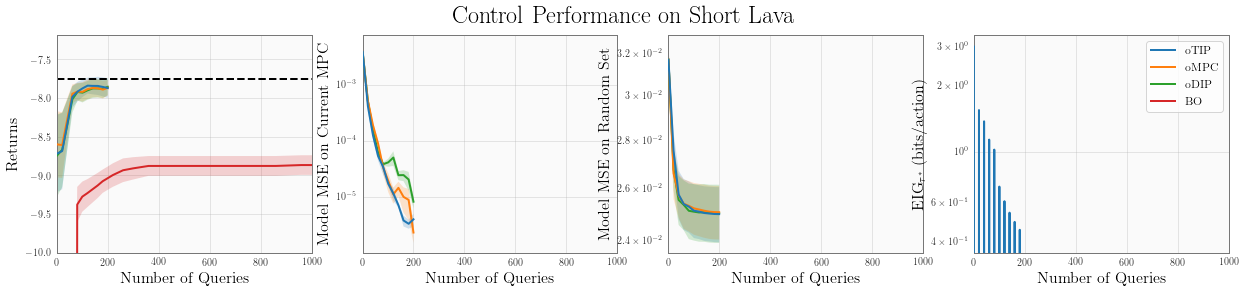

In [808]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4, figsize=(21, 4))
min_ndata = np.inf
normalize_information = True
for i, (key, vals) in enumerate(data.items()):
    rmean = vals["Eval Mean Returns"]
    rstderr = vals["Eval Std Returns"]
    ndata = vals['Eval ndata']
    if max(ndata)  < min_ndata:
        min_ndata = 1000#  max(ndata)
    ax1.plot(ndata[:len(rmean)], rmean, label=key, zorder=100 - i)
    ax1.fill_between(ndata[:len(rmean)], rmean - rstderr, rmean + rstderr, alpha=0.2)
    ylim_top = (gt_val - bottom_val) * 0.25 + gt_val
    ax1.set_ylim(bottom_val, ylim_top)
    if 'Model MSE' in vals:
        mses = vals['Model MSE']
        ax2.plot(ndata[:len(mses)], mses, label=key)
    elif 'Model MSE (current MPC)' in vals:
        mses = vals['Model MSE (current MPC)']
        ax2.plot(ndata[:len(mses)], mses, label=key)
    elif 'Model MSE (current real MPC)' in vals:
        mses = vals['Model MSE (current real MPC)']
        ax2.plot(ndata[:len(mses)], mses, label=key)
    elif "Mean MPC MSEs" in vals:
        mses = vals["Mean MPC MSEs"]
        stds = vals["Std MPC MSEs"]
        ax2.plot(ndata[:len(mses)], mses, label=key, zorder=100-i)
        ax2.fill_between(ndata[:len(mses)], mses - stds, mses + stds, alpha=0.2)
    else:
        print(f"No MPC MSE for {key}")
    if 'Model MSE (random test set)' in vals:
        mses = vals['Model MSE (random test set)']
        ax3.plot(ndata[:len(mses)], mses, label=key)
    elif "Mean Random MSEs" in vals:
        mses = vals["Mean Random MSEs"]
        stds = vals["Std Random MSEs"]
        ax3.plot(ndata[:len(mses)], mses, label=key, zorder=100-i)
        ax3.fill_between(ndata[:len(mses)], mses - stds, mses + stds, alpha=0.2)
    else:
        print(f"No Random MSE for {key}")
    if 'Acquisition Function Value' in vals:
        acqs = vals['Acquisition Function Value']
        if normalize_information and key in rollout_methods:
            acqs /= eig_horizon
        ax4.plot(acqs, label=key)
    elif "Mean Acq Fn Val" in vals:
        acqvals = vals['Mean Acq Fn Val']
        if normalize_information and key in rollout_methods:
            acqvals /= eig_horizon
        stds = vals['Std Acq Fn Val']
        if normalize_information and key in rollout_methods:
            stds /= eig_horizon
        idx = np.arange(len(acqvals))
        ax4.plot(idx, acqvals, label=key, zorder=100-i)
        ax4.fill_between(idx, acqvals - stds, acqvals + stds, alpha=0.2)
    else:
        ax4.plot([], label=key)

crop_to_min_data = True
if crop_to_min_data:
    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_xlim(0, min_ndata)
        
ax1.set_xlabel('Number of Queries', fontsize=16)
ax1.set_ylabel('Returns', fontsize=16)
ax1.axhline(gt_val, color='black', linestyle='--', label=r'$\pi_T$')
ax4.legend(prop={"size": 12}, facecolor="white").set_zorder(101)
ax2.set_xlabel('Number of Queries', fontsize=16)
ax2.set_ylabel('Model MSE on Current MPC', fontsize=16)
ax3.set_ylabel("Model MSE on Random Set", fontsize=16)
ax3.set_xlabel('Number of Queries', fontsize=16)
ax4.set_xlabel('Number of Queries', fontsize=16)
if normalize_information:
    label = r'$\EIG_{\tau^*}$ (bits/action)'
else:
    label = r'$\EIG_{\tau^*}$'
ax4.set_ylabel(label, fontsize=16)
if env_name == 'Lava Path':
    ax1.set_ylim(-1000, 0)
ax2.set_yscale('log')
ax3.set_yscale('log')
ax4.set_yscale('log')
#ax1.set_xscale('log')

fig.suptitle(f"Control Performance on {env_name}", fontsize=24)
neatplot.save_figure(f"all_{env_name}", ["png", "pdf"])

Text(0.5, 1.0, 'Control Performance on Short Lava')

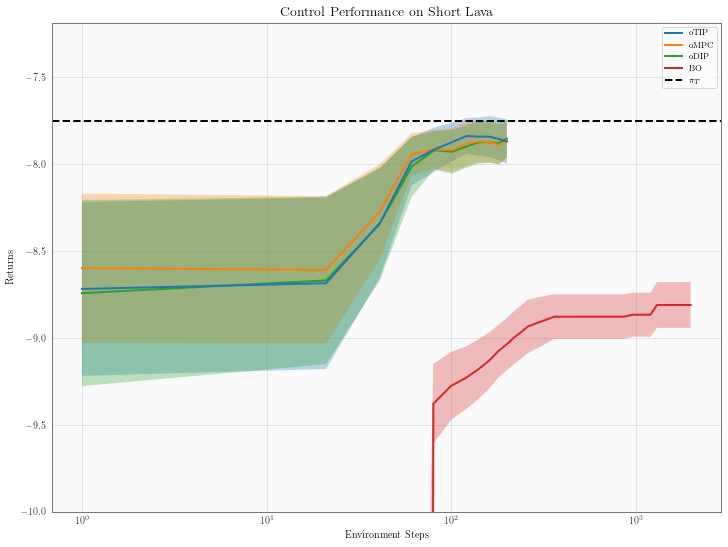

In [809]:
fig, ax = plt.subplots(figsize=(12, 9))
for i, (key, vals) in enumerate(data.items()):
    rmean = vals["Eval Mean Returns"]
    rstderr = vals["Eval Std Returns"]
    ndata = vals['Eval ndata']
    ax.plot(ndata, rmean, label=key, zorder=100 - i)
    ax.fill_between(ndata, rmean - rstderr, rmean + rstderr, alpha=0.3)
ax.set_xlabel('Environment Steps')
ax.set_ylabel('Returns')
ax.axhline(gt_val, color='black', linestyle='--', label=r'$\pi_T$')
ax.legend()
ylim_top = (gt_val - bottom_val) * 0.25 + gt_val
ax.set_ylim(bottom_val, ylim_top)
ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(0, 500)
# ax.set_ylim(-10000, 0)

title = f"Control Performance on {env_name}"
ax.set_title(label=title, fontdict={'fontsize': 14})
# fig.suptitle()

# plt.savefig(f'sample_complexity_{env_name}.pdf') #, bbox_inches='tight')

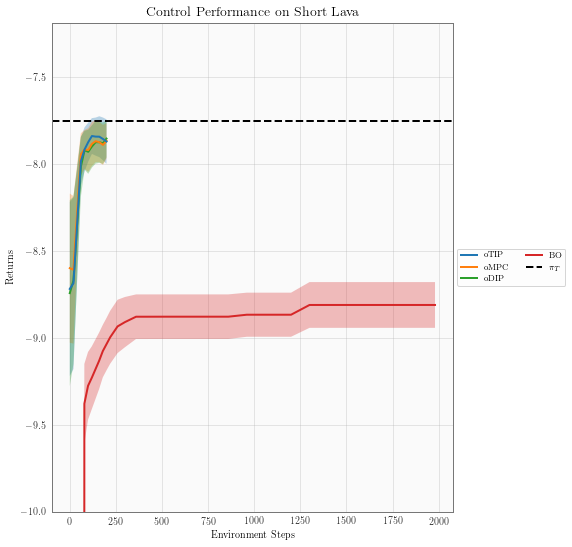

In [810]:
fig, ax = plt.subplots(figsize=(12, 9))
for i, (key, vals) in enumerate(data.items()):
    rmean = vals["Eval Mean Returns"]
    rstderr = vals["Eval Std Returns"]
    ndata = vals['Eval ndata']
    ax.plot(ndata, rmean, label=key, zorder=100 - i)
    ax.fill_between(ndata, rmean - rstderr, rmean + rstderr, alpha=0.3)
ax.set_xlabel('Environment Steps')
ax.set_ylabel('Returns')
ax.axhline(gt_val, color='black', linestyle='--', label=r'$\pi_T$')
# ax.legend()
ylim_top = (gt_val - bottom_val) * 0.25 + gt_val
ax.set_ylim(bottom_val, ylim_top)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(0, 500)
# ax.set_ylim(-10000, 0)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.6, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, fancybox=True)

title = f"Control Performance on {env_name}"
ax.set_title(label=title, fontdict={'fontsize': 14})
# fig.suptitle()
plt.savefig(f'legend_{env_name}.pdf') #, bbox_inches='tight')

In [811]:
print(f"Sample complexity of algorithms on {env_name}")
for key, vals in data.items():
    if 'Eval Seed Returns' in vals:
        samps = []
        for row in vals['Eval Seed Returns']:
            try:
                sample_idx = np.where(row > gt_val)[0].min()
                samps.append(vals['Eval ndata'][sample_idx])
            except ValueError:
                samps.append(np.inf)
        print(f"{key}: {sorted(samps)}")
        mean = np.mean(samps)
        stderr = np.std(samps) / np.sqrt(5)
        print(f"{mean=}, {stderr=}")
        if max(samps) == np.inf:
            ndata = vals['Eval ndata']
            print(f"{key}: {max(ndata)}")
        continue
    rmean = vals["Eval Mean Returns"]
    try:
        sample_idx = np.where(rmean > gt_val)[0].min()
        sample_complexity = vals['Eval ndata'][sample_idx]
    except ValueError:
        sample_complexity = None
    
    print(f"{key}: {sample_complexity}")
    
    

Sample complexity of algorithms on Short Lava
oTIP: [1.0, 21.0, 41.0, 101.0, inf]
mean=inf, stderr=nan
oTIP: 200.0
oMPC: [21.0, 41.0, 101.0, inf, inf]
mean=inf, stderr=nan
oMPC: 200.0
oDIP: [21.0, 81.0, 101.0, inf, inf]
mean=inf, stderr=nan
oDIP: 200.0
BO: [inf, inf, inf, inf, inf]
mean=inf, stderr=nan
BO: 1980.0


/home/viraj/src/bayes-active-rl/venvbarl/lib/python3.9/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


(-1.0, 20.0)

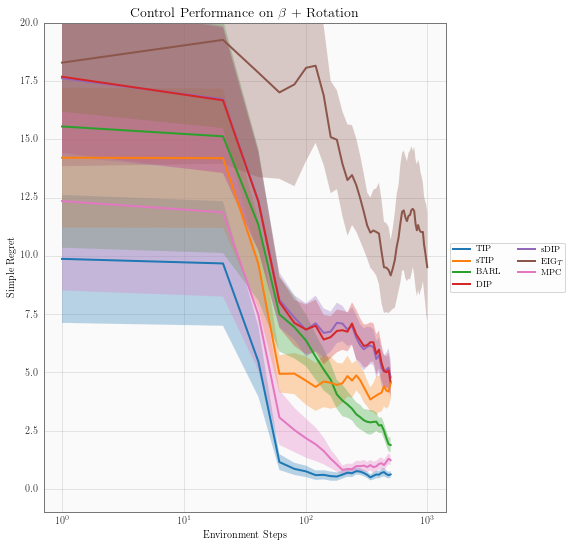

In [692]:
fig, ax = plt.subplots(figsize=(12, 9))
for i, (key, vals) in enumerate(data.items()):
    rmean = gt_val - vals["Eval Mean Returns"]
    rstderr = vals["Eval Std Returns"]
    ndata = vals['Eval ndata']
    ax.plot(ndata, rmean, label=key, zorder=100 - i)
    ax.fill_between(ndata, rmean - rstderr, rmean + rstderr, alpha=0.3)
ax.set_xlabel('Environment Steps')
ax.set_ylabel('Simple Regret')
# ax.axhline(gt_val, color='black', linestyle='--', label=r'$\pi_T$')
# ax.legend()
ylim_top = (gt_val - bottom_val) * 0.25 + gt_val
# ax.set_ylim(bottom_val + gt_val, (gt_val - bottom_val) * 0.25)
ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(0, 200)
# ax.set_ylim(-10000, 0)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.6, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, fancybox=True)

title = f"Control Performance on {env_name}"
ax.set_title(label=title, fontdict={'fontsize': 14})

ax.set_ylim(-1, 20)

Text(0.5, 1.0, 'Control Performance on Reacher')

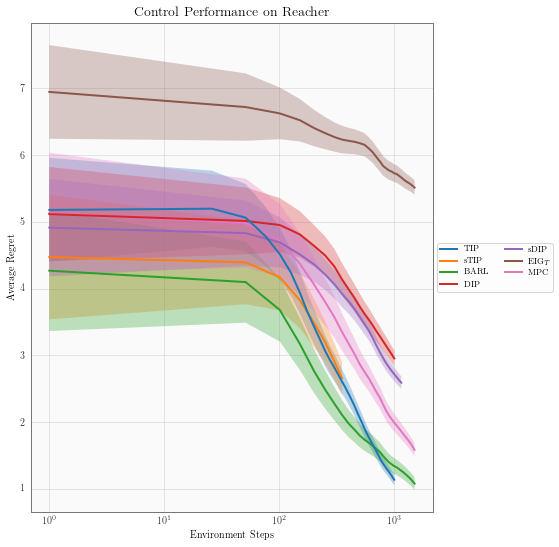

In [600]:
fig, ax = plt.subplots(figsize=(12, 9))
for i, (key, vals) in enumerate(data.items()):
    rmean = gt_val - vals["Eval Mean Returns"]
    rstderr = vals["Eval Std Returns"]
    ndata = vals['Eval ndata']
    cum_mean = np.cumsum(rmean) / np.arange(1, len(rmean) + 1)
    cum_stderr = np.sqrt(np.cumsum(np.square(rstderr))) / np.arange(1, len(rmean) + 1)
    ax.plot(ndata, cum_mean, label=key, zorder=100 - i)
    ax.fill_between(ndata, cum_mean - cum_stderr, cum_mean + cum_stderr, alpha=0.3)
ax.set_xlabel('Environment Steps')
ax.set_ylabel('Average Regret')
# ax.axhline(gt_val, color='black', linestyle='--', label=r'$\pi_T$')
# ax.legend()
# ylim_top = (gt_val - bottom_val) * 0.25 + gt_val
# ax.set_ylim(bottom_val + gt_val, (gt_val - bottom_val) * 0.25)
ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(0, 200)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.6, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, fancybox=True)

title = f"Control Performance on {env_name}"
ax.set_title(label=title, fontdict={'fontsize': 14})

